<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных-и-лемматизация" data-toc-modified-id="Обзор-данных-и-лемматизация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных и лемматизация</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#GridSearchCV" data-toc-modified-id="GridSearchCV-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>GridSearchCV</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Вывод-2" data-toc-modified-id="Вывод-2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Вывод 2</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Импорт и функции


In [1]:
#lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import joblib
import spacy
from nltk.corpus import stopwords as nltk_stop
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    roc_curve,
    plot_confusion_matrix
)
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
tqdm.pandas()
#подготовка nlp
#загрузка
nltk.download('wordnet')
stopwords = set(nltk_stop.words('english'))
#nlp pipeline from spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#очистка текста и приведение к регистру
def preprocessing(text, spacy = nlp): 
    text = text.lower() 
    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text) 
    text = re.sub("[^a-zA-Z]", " ", text)
    while "  " in text: 
        text = text.replace("  ", " ") 
    text = text.strip() 
    text = spacy(text)
    return " ".join([token.lemma_ for token in text])

In [3]:
#roc-auc score plot
def roc_auc_plot (features_valid, target_valid, model, x, y):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure(figsize=(x,y))
    # построение графика
    plt.plot(fpr, tpr)
    # вводим ROC кривую случайной модели со значением 0.5
    plt.plot([0, 1], [0, 1], linestyle='--')
    #границы графиков
    plt.xlim(0,1)
    plt.ylim(0,1)
    #подписи осей
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #заголовок
    plt.title('ROC-кривая', fontsize = 12)
    plt.show()
    

In [4]:
#style
plt.style.use('bmh')
np.set_printoptions(precision=3)

## Подготовка

### Обзор данных и лемматизация

In [70]:
#read .csv
data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)

In [71]:
#df head
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [73]:
#data info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


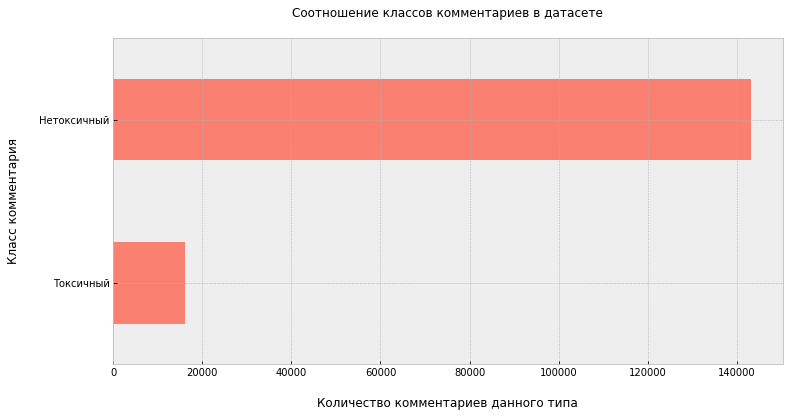

In [74]:
#красивый график
(
    data['toxic']
    .value_counts()
    .sort_values()
    .plot(
        kind = 'barh',
        figsize = (12,6),
        color = 'salmon'
    )
)
classes = ['Токсичный','Нетоксичный']
y_pos = np.arange(len(classes))
plt.xlabel("\n" + 'Количество комментариев данного типа')
plt.ylabel('Класс комментария' + "\n")
plt.yticks(y_pos,labels = classes)
plt.title('Cоотношение классов комментариев в датасете' + '\n', fontsize = 12);

Наблюдается дисбаланс классов. Учтем это во время обучения моделей и нивелируем за счет весов классов

**Лемматизация**

In [ ]:
%%time
#V2
#генерируем леммы слов c очисткой
data['lemm'] = data['text'].apply(preprocessing)

In [ ]:
#check
data.head()

In [ ]:
#удалим исходный столбец с текстом для экономии памяти
data.drop('text',axis=1, inplace = True)

In [ ]:
#теперь сохраним датафрейм с леммами
data.to_csv("nlp_12/lemm.csv")

In [ ]:
#final df
data.sample(10)

### Создание признаков

Загрузим ранее созданный датафрейм с обработанными словами

In [5]:
#лемматизированный датафрейм
df = pd.read_csv('nlp_12/lemm.csv',index_col = 0)

In [6]:
#check
df.head()

,toxic,lemm
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour I m seem...
2,0,hey man I m really not try to edit war it s ju...
3,0,more I can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


In [7]:
#size
df.shape

(159292, 2)

In [8]:
#check
df.isna().sum()

toxic     0
lemm     25
dtype: int64

In [9]:
#dropna
df = df.dropna()

In [10]:
#check
df.isna().sum()

toxic    0
lemm     0
dtype: int64

In [12]:
#баланс классов
display((df['toxic'].value_counts()))
balance = (df['toxic'].value_counts()[0])/(df['toxic'].value_counts()[1])
print(f'Класс 0 : Класс 1 = {balance}')

0    143082
1     16185
Name: toxic, dtype: int64

Класс 0 : Класс 1 = 8.840407784986098


In [11]:
#разбиваем на выборки со стратификацией
features_train, features_test, target_train, target_test = \
train_test_split(df['lemm'],df['toxic'],test_size=0.25, random_state=21, stratify = df['toxic'])
#check
print('Размер обучающей выборки:', features_train.shape[0])
#check
print('Размер тестовой выборки:', features_test.shape[0])
#условие равенства выборок
features_train.shape[0] + features_test.shape[0] == df['lemm'].shape[0]

Размер обучающей выборки: 119450
Размер тестовой выборки: 39817


True

In [13]:
#check
features_train.shape[0] == target_train.shape[0]

True

In [14]:
#check
features_test.shape[0] == target_test.shape[0]

True

In [ ]:
# #создаем векторизатор
# count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))
# #применяем векторизатор
# features_train = count_tf_idf.fit_transform(features_train['lemm'].values.astype('U'))
# features_test = count_tf_idf.transform(features_test['lemm'].values.astype('U'))

### Вывод

- в исходном датасете удалили ненужный столбец
- в данных нет пропусков
- обнаружен дисбаланс классов, это будет учтено при подборке гиперпараметров и обучении моделей
- исходные тексты очищены от лишних символов, слова приведенны к их леммам
- созданы выборки для обучения путем векторизации текстов

## Обучение

Рассмотрим три классификатора:  

1) **logistic classifier**  

2) **random forest classifier**  

3) **catboost calssifier**

Для борьбы с дисбалансом создадим словарь с соотношением классов в выборке

### GridSearchCV

In [15]:
#словарь 
dict_classes={0:1, 1:8.84}
#check
dict_classes

{0: 1, 1: 8.84}

#### LogisticRegression

In [62]:
#параметры для GS
lr_params={'model__C':[0.1,0.5,1,3,5],
           'model__solver':['lbfgs', 'liblinear']
          }

#pipeline для регрессии
lr_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
                         ('model',LogisticRegression(max_iter = 500,
                                                     class_weight = dict_classes,
                                                     random_state = 21,
                                                     tol = 1e-3))])
    
#gridsearch initialization
lr_grid = GridSearchCV(lr_pipeline, cv = 3, param_grid=lr_params,
                       scoring='f1',verbose = 1, n_jobs = -1)

In [18]:
%%time
#fit
lr_grid.fit(features_train, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=  13.5s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=  15.3s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=  14.0s
[CV] END ..............model__C=0.1, model__solver=liblinear; total time=   9.8s
[CV] END ..............model__C=0.1, model__solver=liblinear; total time=   9.8s
[CV] END ..............model__C=0.1, model__solver=liblinear; total time=   9.5s
[CV] END ..................model__C=0.5, model__solver=lbfgs; total time=  40.6s
[CV] END ..................model__C=0.5, model__solver=lbfgs; total time=  34.5s
[CV] END ..................model__C=0.5, model__solver=lbfgs; total time=  37.2s
[CV] END ..............model__C=0.5, model__solver=liblinear; total time=  13.6s
[CV] END ..............model__C=0.5, model__solver=liblinear; total time=  14.7s
[CV] END ..............model__C=0.5, model__solv

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['don', 've',
                                                                    'was',
                                                                    "should've",
                                                                    'will',
                                                                    'few',
                                                                    'hadn',
                                                                    'we',
                                                                    "wasn't",
                                                                    'other',
                                                                    "won't",
                                                                    'this',
                                                                    'about',
         

In [47]:
#score
lr_grid.best_score_

0.7617221558348996

In [43]:
#best model
joblib.dump(lr_grid.best_estimator_['model'], 'nlp_12/lr_last.pkl')

['nlp_12/lr_last.pkl']

In [29]:
#feature importance
coefficients = lr_grid.best_estimator_['model'].coef_[0]

In [30]:
#tfidf words
tf_voc = lr_grid.best_estimator_['tfidf'].vocabulary_

Выделим наиболее значимые слова с точки зрения классификатора

In [32]:
tfidf_map = [(x, tf_voc[x]) for x in tf_voc]
tfidf_map[:10]

[('november', 75402),
 ('ignore', 50530),
 ('wp', 120251),
 ('breach', 14177),
 ('conlimite', 22060),
 ('replace', 90201),
 ('well', 117887),
 ('cite', 19641),
 ('contend', 22499),
 ('undo', 112548)]

In [33]:
tfidf_map.sort(key = lambda x: x[1])
tfidf_map[:5]

[('aa', 0),
 ('aaa', 1),
 ('aaaa', 2),
 ('aaaaaaaaaah', 3),
 ('aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 4)]

In [34]:
vocab_tf = [x[0] for x in tfidf_map]
vocab_tf[:10]

['aa',
 'aaa',
 'aaaa',
 'aaaaaaaaaah',
 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaw',
 'aaaaah',
 'aaaah',
 'aaaannnnyyyywwwwhhhheeeerrrreeee']

In [35]:
coef_df = pd.DataFrame(list(zip(vocab_tf,coefficients)),
                      columns = ['word','coef'])

In [38]:
#top-10 words
coef_df.sort_values('coef', ascending = False).head(10)

,word,coef
40459,fuck,36.487001
40489,fucking,28.106262
97433,shit,24.640921
50357,idiot,23.856181
15216,bullshit,21.048849
7219,ass,20.861410
7296,asshole,20.566596
103143,stupid,20.490303
12251,bitch,20.411333
103581,suck,19.626432


#### Decision Tree

In [41]:
#параметры для GS
tree_params={'model__max_depth':[x for x in range(1,12,1)],
             'model__class_weight':[dict_classes]
            }

#pipeline для регрессии
tree_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
                         ('model',DecisionTreeClassifier(random_state = 21))])
    
#gridsearch initialization
tree_grid = GridSearchCV(tree_pipeline, cv = 3, param_grid=tree_params,
                       scoring='f1',verbose = 1, n_jobs = -1)

In [ ]:
%%time
#tree grid search
tree_grid.fit(features_train, target_train)

In [48]:
#score
tree_grid.best_score_

0.5640161980013109

In [44]:
#best_estimator
#best model
joblib.dump(tree_grid.best_estimator_['model'], 'nlp_12/decision_tree.pkl')

['nlp_12/decision_tree.pkl']

 #### CatBoost

In [49]:
#параметры для GS
cat_params={'model__learning_rate':[x/10 for x in range(1,5,1)],
             'model__depth': [x for x in range (2,6,1)]
            }

#pipeline для регрессии
cat_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
                         ('model',CatBoostClassifier(random_state = 21,
                                                    class_weights = dict_classes,
                                                    iterations = 150))])
    
#gridsearch initialization
cat_grid = GridSearchCV(cat_pipeline, cv = 3, param_grid=cat_params,
                       scoring='f1',verbose = 1, n_jobs = -1)

In [ ]:
%%time
#catboost fit
cat_grid.fit(features_train,target_train)

In [52]:
#score
cat_grid.best_score_

0.7400436713980575

In [53]:
#save model
joblib.dump(cat_grid.best_estimator_['model'],'nlp_12/catboost.pkl')

['nlp_12/catboost.pkl']

### Вывод 2

По итогам кросс-валидации получены следующие результаты:
- LogisticRegression - 0.761
- DecisionTree - 0.564
- CatBoost - 0.74
Для дальнейшего тестирования используем модель **логистической регрессии**

## Тестирование

In [63]:
#dummy classifier
dummy = DummyClassifier(strategy = 'constant', random_state = 21,
                       constant = 1)
dummy.fit(features_train, target_train)
dummy_preds = dummy.predict(features_test)
dummy_score = f1_score(dummy_preds,target_test)
print('Dummy F1 score:', dummy_score)

Dummy F1 score: 0.18448350546018283


In [64]:
#pipeline для тестирования регрессии
lr_test_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
                         ('model',log_test)])

In [65]:
#fit test
lr_test_pipeline.fit(features_train, target_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['don', 've', 'was', "should've",
                                             'will', 'few', 'hadn', 'we',
                                             "wasn't", 'other', "won't", 'this',
                                             'about', 'won', 'any', "you'll",
                                             'ma', 'here', 'than', 'while',
                                             "you're", 'itself', 'her', 'or',
                                             'ourselves', 'couldn', 'wasn',
                                             'out', 'has', 'further', ...])),
                ('model',
                 LogisticRegression(C=5, random_state=21, solver='liblinear'))])

In [66]:
#test_score
preds = lr_test_pipeline.predict(features_test)
lr_test_score = f1_score(preds,target_test)
print('Logistic Regression F1 score:', lr_test_score)

Logistic Regression F1 score: 0.7841129255466371


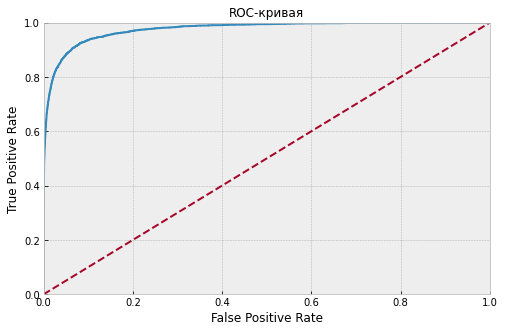

In [67]:
#roc-auc
roc_auc_plot(features_test,target_test,lr_test_pipeline,8,5)

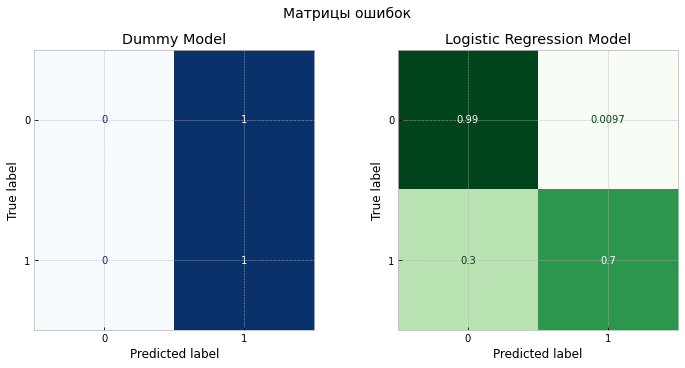

In [69]:
#confusion matrixes
fig,axes = plt.subplots(1,2,figsize = (10,5),constrained_layout = True)
fig.suptitle('Матрицы ошибок', fontsize = 14)
dummy_disp = plot_confusion_matrix(dummy, 
                                   features_test, 
                                   target_test,
                                   cmap=plt.cm.Blues,
                                   normalize='true',
                                   ax = axes[0],
                                   colorbar = False)
logr_disp = plot_confusion_matrix(lr_test_pipeline, 
                                  features_test, 
                                  target_test,
                                  cmap=plt.cm.Greens,
                                  normalize='true',
                                  ax = axes[1],
                                  colorbar = False
                                 )
axes[0].set_title('Dummy Model')                     
axes[1].set_title('Logistic Regression Model');

## Выводы

- рассмотрены три модели - **CatBoost, Logistic Regression и DecisionTreeClassifier**
- для них подобраны некоторые оптимальные гиперпараметры
- выбранна модель **логистической регрессии**, поскольку она показала наилучший результат
- на тестовой выборке получено значение `F1 = 0.784`, что удовлетворяет требованиям ТЗ